# Classify breast cancer histopathological images

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from PIL import Image

SEED = 1234

C:\Users\aggou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

Exploratory Data Analysis

The file `Folds.csv` contains all image files' path and filename. It includes a 5-fold cross-validation strategy. I will read it into a dataframe and find each file's main type label(benign or malignant) and sub-type label.

In [3]:
def get_subtype(x):
    x = x.split("/")[-1]
    x = x.split('-')[0]
    return x.split('_')[2]

pd.set_option('display.max_columns', 10)
fold_data = pd.read_csv("C:/Users/aggou/Downloads/archive/Folds.csv")
# Get the real path of file in kaggle
fold_data['filename'] = ("C:/Users/aggou/Downloads/archive/BreaKHis_v1/"+fold_data["filename"])
#Find the main type label and sub type label for each image
fold_data["main_type"] = fold_data["filename"].str.extract("(malignant|benign)")
fold_data["sub_type"] = fold_data["filename"].apply(lambda x:get_subtype(x))
fold_data

fold  mag    grp                                           filename  \
0         1  100  train  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
1         1  100  train  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
2         1  100  train  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
3         1  100  train  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
4         1  100  train  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
...     ...  ...    ...                                                ...   
39540     5  400   test  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
39541     5  400   test  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
39542     5  400   test  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
39543     5  400   test  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   
39544     5  400   test  C:/Users/aggou/Downloads/archive/BreaKHis_v1/B...   

       main_type sub_type  
0         benign        A  
1         benign        A  
2         benign        A  
3         benign        A  
4         benign        A  
...          ...      ...  
39540  malignant       PC  
39541  malignant       PC  
39542  malignant       PC  
39543  malignant       PC  
39544  malignant       PC  

[39545 rows x 6 columns]

Count and visualize the statistics of the dataset.

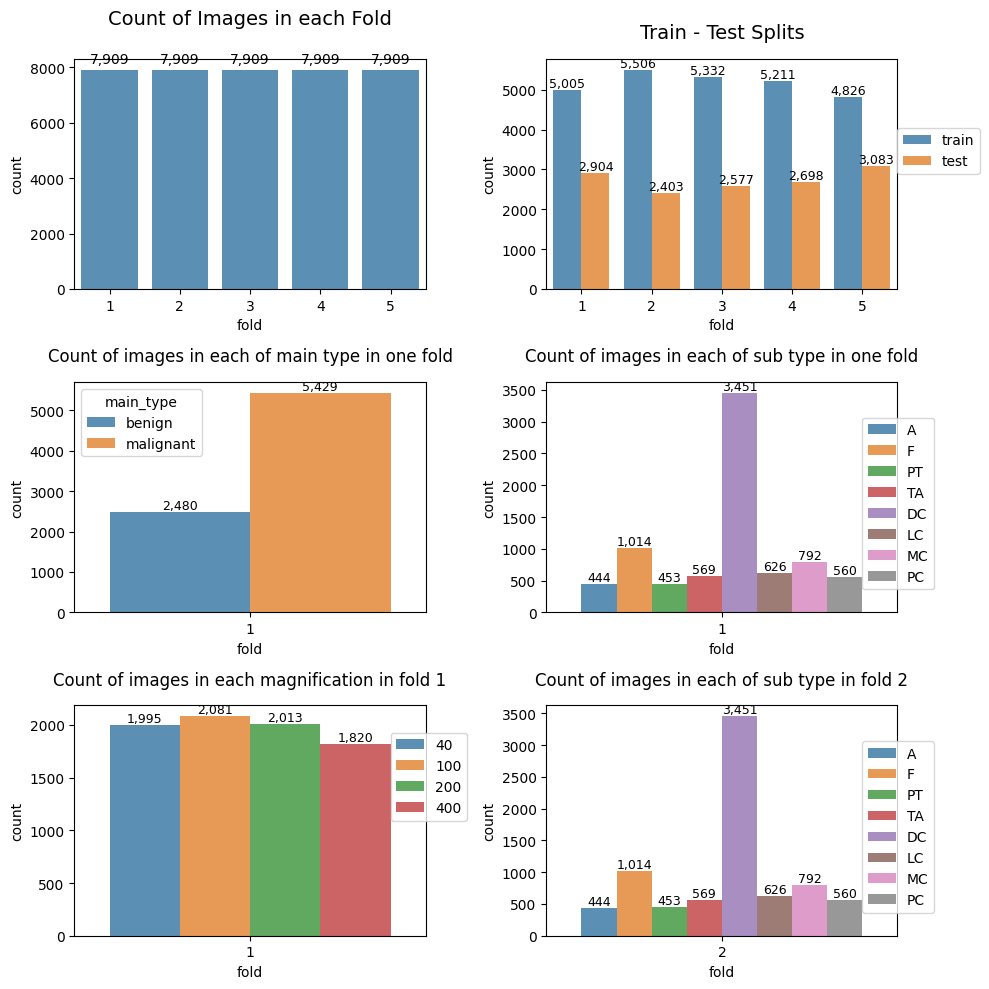

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), tight_layout=True)
# Plot image count in each fold
sb.countplot(data=fold_data, x="fold", color="C0", ax=ax[0][0], alpha=0.8)
bars = ax[0][0].containers[0]
ax[0][0].bar_label(bars, padding=3,
                labels=[f"{x:,.0f}" for x in bars.datavalues])

ax[0][0].set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_data, x="fold", hue="grp", palette="tab10",
              ax=ax[0][1], alpha=0.8)
for bars in ax[0][1].containers:
    ax[0][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    
ax[0][1].set_title("Train - Test Splits", size=14, pad=15)
ax[0][1].legend(loc=(1, 0.5));

# Plot image count in each main type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="main_type", palette="tab10",
              ax=ax[1][0], alpha=0.8)
for bars in ax[1][0].containers:
    ax[1][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    
ax[1][0].set_title("Count of images in each of main type in one fold", size=12, pad=15)


# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="sub_type", palette="tab10",
              ax=ax[1][1], alpha=0.8)
for bars in ax[1][1].containers:
    ax[1][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    
ax[1][1].set_title("Count of images in each of sub type in one fold", size=12, pad=15)
ax[1][1].legend(loc=(0.9, 0.1))

# Plot image count in each magnification
sb.countplot(data=fold_data[fold_data.fold==1], x="fold", hue="mag", palette="tab10",
              ax=ax[2][0], alpha=0.8)
for bars in ax[2][0].containers:
    ax[2][0].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    
ax[2][0].set_title("Count of images in each magnification in fold 1", size=12, pad=15)
ax[2][0].legend(loc=(0.9, 0.5))

# Plot image count in each sub type
sb.countplot(data=fold_data[fold_data.fold==2], x="fold", hue="sub_type", palette="tab10",
              ax=ax[2][1], alpha=0.8)
for bars in ax[2][1].containers:
    ax[2][1].bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    
ax[2][1].set_title("Count of images in each of sub type in fold 2", size=12, pad=15)
ax[2][1].legend(loc=(0.9, 0.1))

Prepare train and test data

Choose any fold dataset (eg. fold 1), split it into train set (70%) and test set (30%) 

In [5]:
img_data = fold_data[fold_data.fold==1].drop(columns=['fold','grp'])
test = img_data.sample(frac=0.3,random_state=SEED)
train = img_data.drop(test.index)
train.reset_index(inplace=True)
train.drop(columns=['index'],inplace=True)
test.reset_index(inplace=True)
test.drop(columns=['index'],inplace=True)
train.shape,test.shape

((5536, 4), (2373, 4))

Labelencode the main type into numeric [0,1].

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train2 = le.fit_transform(train.main_type)
y_test2 = le.transform(test.main_type)
main_classname = list(le.classes_)

Let's view some sample images.

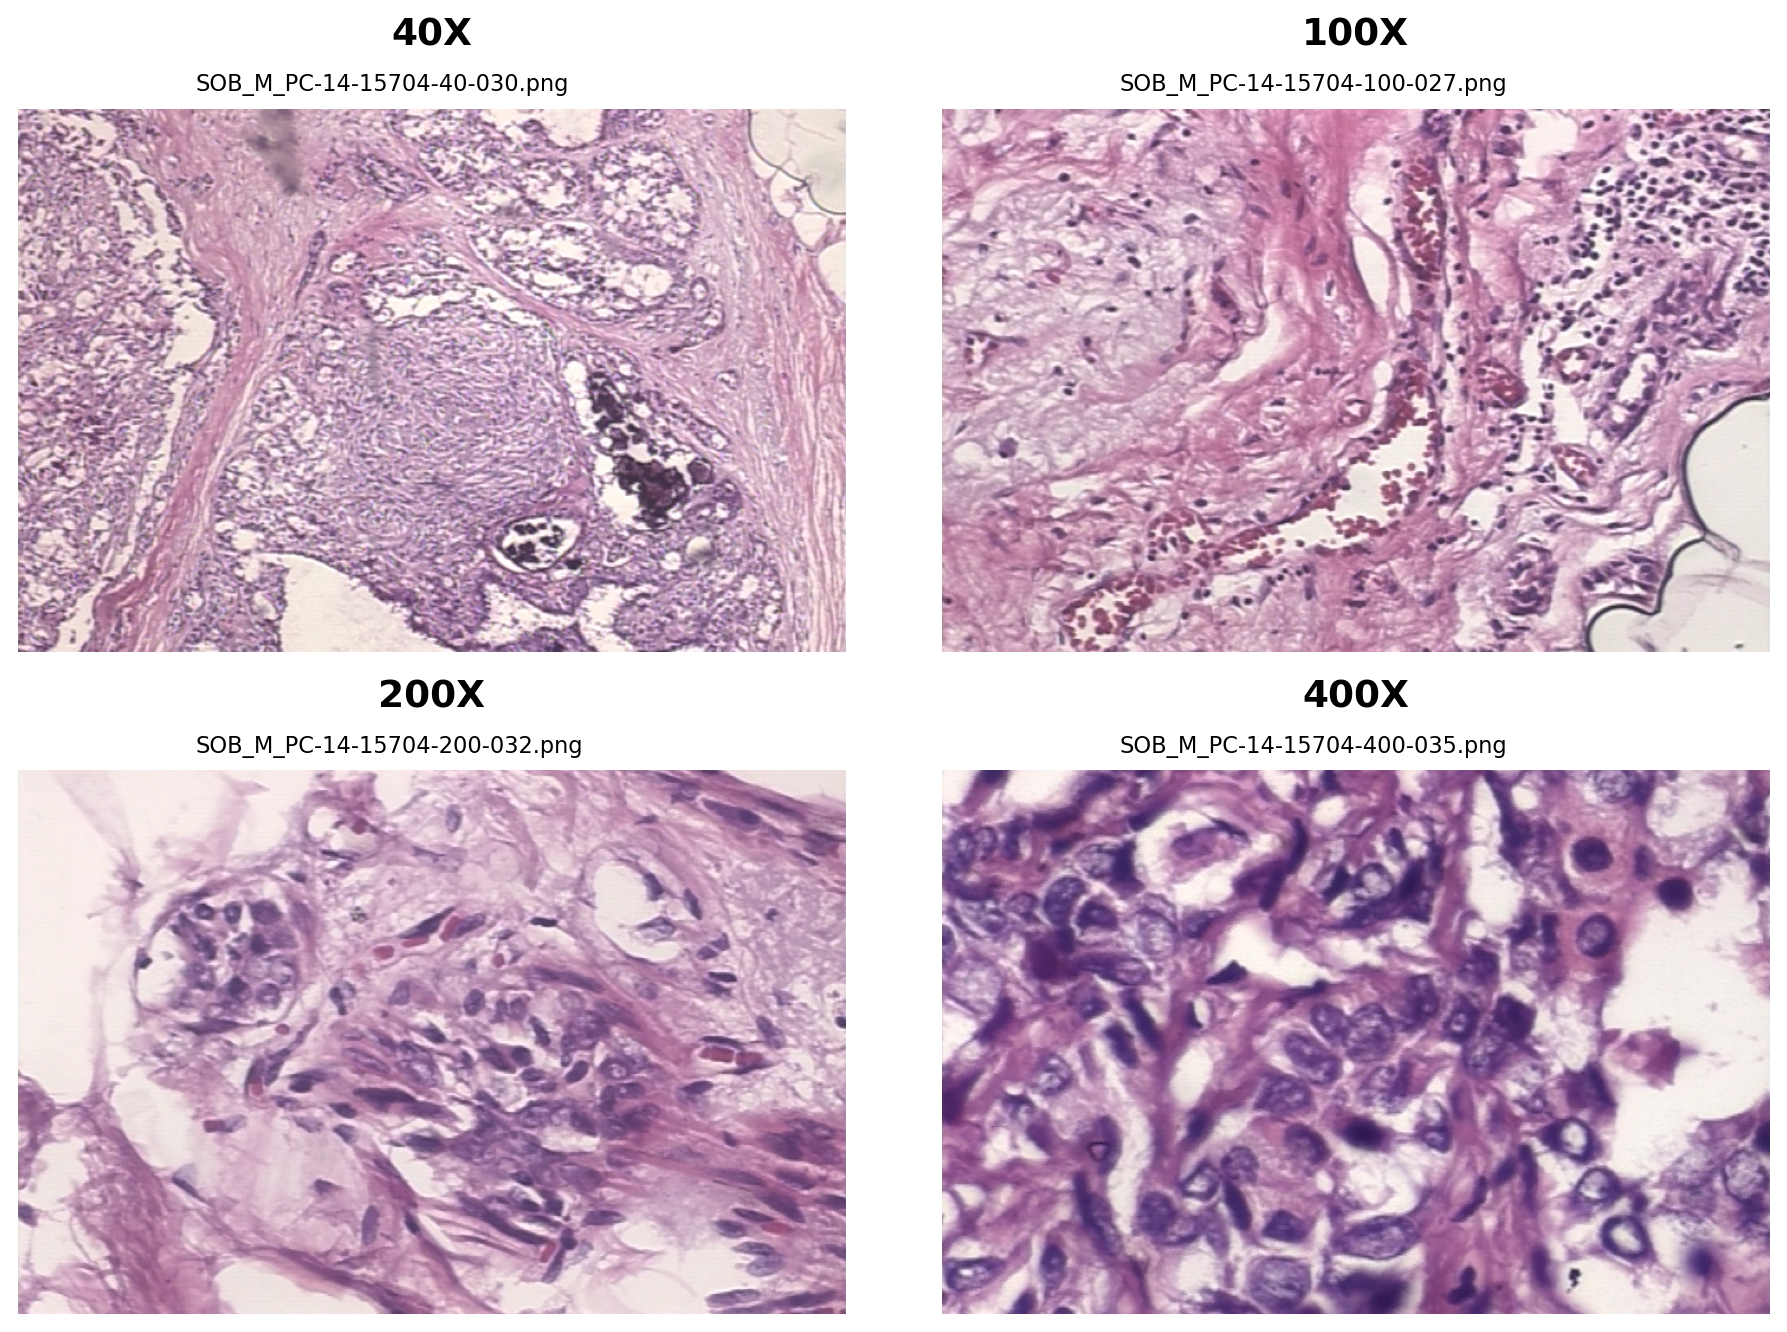

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = train.groupby("mag", as_index=False).last()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

Check target Distribution

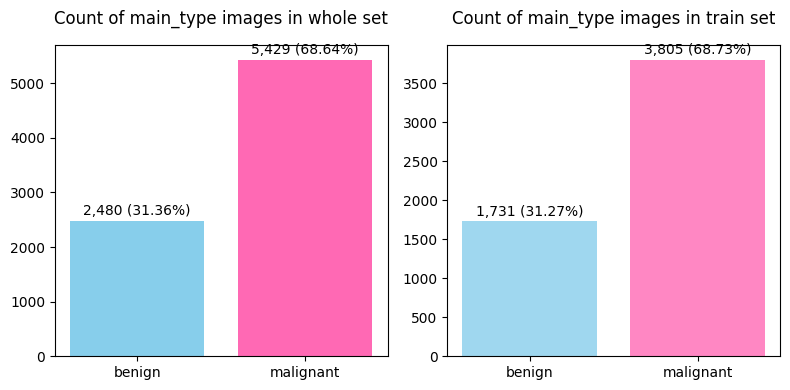

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)

# Plot image count/prop in each main type
main_whole = img_data["main_type"].value_counts(ascending=True)
ax[0].bar(main_whole.index,main_whole,color=["skyblue", "hotpink"])
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in main_whole])
ax[0].set_title("Count of main_type images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type
main_train = train["main_type"].value_counts(ascending=True)
ax[1].bar(main_train.index,main_train,color=["skyblue", "hotpink"], alpha=0.8)                     
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in main_train])
ax[1].set_title("Count of main_type images in train set", size=12, pad=15)
plt.show()

Data Preprocessing

Use pytorch module to load the images and make some tranformation such as flip, resize to convert images into tensor numeric form for consumption by computer vision models. 
Firstly, compute the mean and std of images.

In [9]:

from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH_SIZE = 32
"""
# Define class to load image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df,y):
        self.X = X_df
        self.y = y
        self.T = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor()])
    def __len__(self):
        return len(self.X)  
    
    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        return self.T(img),self.y[index]


# load data batch by bathc
loader = DataLoader(
  load_data(train,y_train2), 
  batch_size = 16)


def  img_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    
    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
                                  
        #comput first and second moment batch by batch 
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    img_mean, img_std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return img_mean,img_std
  
img_mean, img_std = img_mean_and_sd(loader)
print("Images' mean and std: \n", img_mean, img_std)   
"""
img_mean=[0.7879, 0.6260, 0.7660]
img_std=[0.1249, 0.1765, 0.1083]

Load and transform the image data

In [10]:
# Define class to load and transform image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.RandomResizedCrop(IMG_SIZE),  
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]
        
# Prepare training and validation datasets for binary classfication
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train2, test_size=0.25, random_state=SEED)
X_train.name = 'train'
X_valid.name = 'val'
test.name = 'test'
train.name = 'train'

# reset index 
X_train.reset_index(inplace=True)
X_train.drop(columns=['index'],inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'],inplace=True)

train_ds = load_data(X_train,y_train)
valid_ds = load_data(X_valid,y_valid)
test_ds = load_data(test,y_test2)

Let's have a look at some of the images:

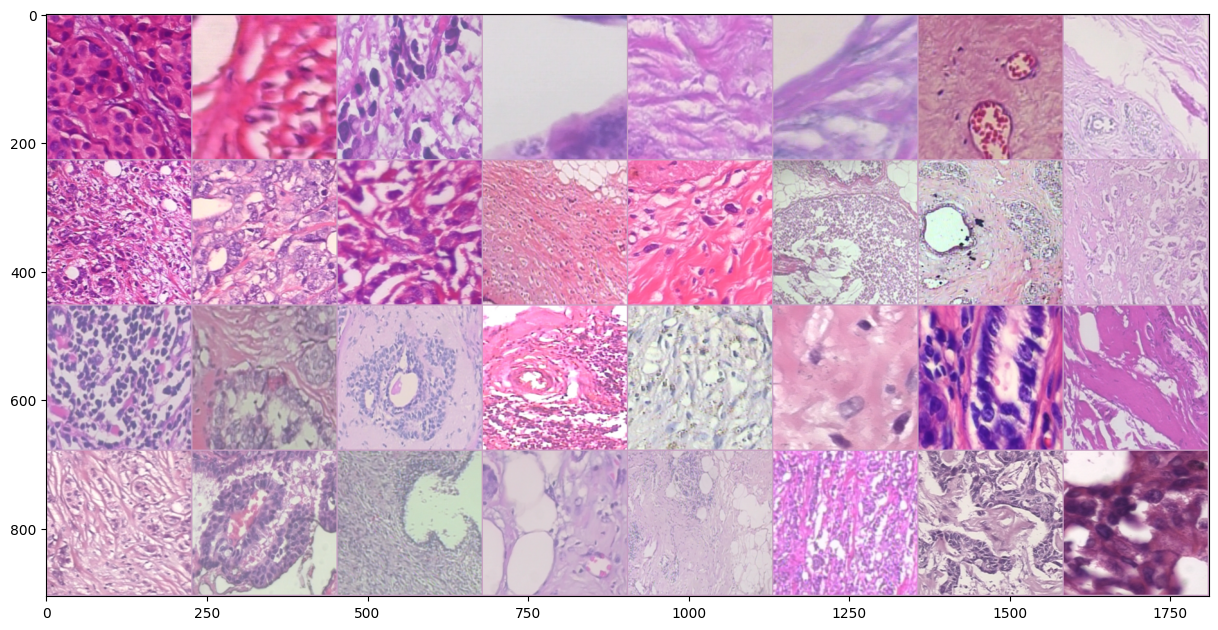

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(img_mean)
    std = np.array(img_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
# Get a batch of training data
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True) 
inputs, classes = next(iter(train_ds1))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Build and train  models

 This is image classification task. Resnet50 pretrained model is good choice to build classifier model. Here use  Resnet50 pretrained model and modify full connection layer as following.

Build resnet50 pretrained model

In [14]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        
        model.fc = nn.Sequential(
             nn.Linear(num_ftrs, 1000),
             nn.ReLU(),
             nn.Linear(1000, 128),
             nn.ReLU(),
             nn.Linear(128, output_features)
        )
        self.model = model
        
    def forward(self, x):
        return self.model(x)
DEVICE = 'cuda'   
prenet = PretrainedModel(2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Search the learning rate

Use torch-lr-finder to search the learning rate range when using different optimizers.

In [ ]:
# !pip install torch-lr-finder

In [16]:
# Search lr when using optimizer SGD
import torch.optim as optim
from torch_lr_finder import LRFinder
"""
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(prenet.parameters(), lr=1E-5, momentum=0.9)
lr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)
lr_finder.range_test(train_ds1, end_lr=3, num_iter=110, step_mode="exp")
lr_finder.plot()
lr_finder.reset()
"""

'\ntrain_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True) \ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.SGD(prenet.parameters(), lr=1E-5, momentum=0.9)\nlr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)\nlr_finder.range_test(train_ds1, end_lr=3, num_iter=110, step_mode="exp")\nlr_finder.plot()\nlr_finder.reset()\n'

Choose learning rate range : [0.001,0.2]

In [17]:
# Search lr when using optimizer Adam 
"""
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(prenet.parameters(), lr=1e-6)
lr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)
lr_finder.range_test(train_ds1, end_lr=0.08, num_iter=120, step_mode="exp")
lr_finder.plot()
lr_finder.reset()
"""

'\ntrain_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE) \ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(prenet.parameters(), lr=1e-6)\nlr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)\nlr_finder.range_test(train_ds1, end_lr=0.08, num_iter=120, step_mode="exp")\nlr_finder.plot()\nlr_finder.reset()\n'

Choose learning rate range : [5E-5,1E-2]

In [18]:
#Search lr when using optimizer Adam with weight_decay
"""
train_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(prenet.parameters(), lr=1e-6, weight_decay=1e-3)
lr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)
lr_finder.range_test(train_ds1, end_lr=0.05, num_iter=120, step_mode="exp")
lr_finder.plot()
lr_finder.reset()
"""

'\ntrain_ds1 = DataLoader(load_data(X_train,y_train), batch_size=BATCH_SIZE) \ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(prenet.parameters(), lr=1e-6, weight_decay=1e-3)\nlr_finder = LRFinder(prenet, optimizer, criterion, device=DEVICE)\nlr_finder.range_test(train_ds1, end_lr=0.05, num_iter=120, step_mode="exp")\nlr_finder.plot()\nlr_finder.reset()\n'

Choose learning rate range : [5E-5,1E-2] 0.01 0.001 0.0001 0.00001

In [19]:
#!curl -o onecyclelr.py  https://raw.githubusercontent.com/dkumazaw/onecyclelr/master/onecyclelr.py
#from onecyclelr import OneCycleLR
#optimizer = torch.optim.SGD(prenet.parameters(), lr=1.E-5, momentum=0.9)
#lrscheduler = OneCycleLR(optimizer, num_steps=len(train_ds1)//2, lr_range=(1.E-5, 1.E-4))

In [20]:
os.mkdir('C:/Users/aggou/Downloads/archive/record')
os.mkdir('C:/Users/aggou/Downloads/archive/record/SGD')
os.mkdir('C:/Users/aggou/Downloads/archive/record/SGD1')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam1')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam2')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam_frez')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam_unfrez')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam_frez_sm')
os.mkdir('C:/Users/aggou/Downloads/archive/record/Adam_unfrez_sm')
os.mkdir('C:/Users/aggou/Downloads/archive/Adam_sm')
os.mkdir('C:/Users/aggou/Downloads/archive/Adam_sm1')
os.mkdir('C:/Users/aggou/Downloads/archive/Adam_sm2')

In [22]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))

Train model with SGD optimizer

Train the model with oneCycle LR scheduler and validate it with predifined validation set.


In [23]:
checkpoint = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/SGD')
lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, 
                          max_lr=0.2,step_size_up=len(train_ds1)//2)
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=32,
    max_epochs=20,
    module__output_features=2,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler, checkpoint],
    # device = 'cuda'
)
_ = net.fit(train_ds,y=None)    

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.6265       0.6886        0.6007     +  0.0010  100.2167
      2        0.4300       0.8931        0.2631     +  0.0041  75.5753
      3        0.2437       0.9205        0.1929     +  0.0071  74.2729
      4        0.1991       0.9400        0.1660     +  0.0102  75.5524
      5        0.1917       0.9364        0.1812        0.0132  75.9176
      6        0.1683       0.9111        0.2141        0.0163  76.1069
      7        0.1601       0.9017        0.2482        0.0194  76.5341
      8        0.1317       0.9559        0.1308     +  0.0224  75.6786
      9        0.1436       0.9306        0.1754        0.0255  74.7440
     10        0.1257       0.9762        0.0841     +  0.0286  76.4347
     11        0.1376       0.9458        0.1414        0.0316  76.4998
     12        0.1216       0.8605        0.4868        0.034

Freeze the parameters of layers except full connection layer, train the model with oneCycle LR scheduler and validate with predifined validation set.

In [24]:
checkpoint = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/SGD1')
lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, 
                          max_lr=0.5,step_size_up=len(train_ds1)//2)
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=20,
    module__output_features=2,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler, checkpoint, freezer],
    # device = 'cuda'
)
_ = net.fit(train_ds,y=None)    

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.6313       0.6886        0.6051     +  0.0010  71.8041
      2        0.4726       0.7355        0.5461     +  0.0087  71.0032
      3        0.3836       0.8772        0.2940     +  0.0164  70.5795
      4        0.3719       0.8786        0.2825     +  0.0240  71.2821
      5        0.3677       0.8757        0.2973        0.0317  71.6400
      6        0.3440       0.8981        0.2574     +  0.0394  71.3634
      7        0.3137       0.8952        0.2659        0.0471  70.7272
      8        0.3260       0.9032        0.2270     +  0.0547  71.2191
      9        0.3020       0.8656        0.3127        0.0624  70.7890
     10        0.2911       0.8996        0.2581        0.0701  71.1813
     11        0.3183       0.8981        0.2466        0.0778  70.6964
     12        0.3377       0.8916        0.2766        0.0854  

Then, unfreeze all freezed parameters, load the above best parameters and train the model with smaller STEP learning rate.

In [25]:


checkpoint = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/SGD1')
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0001,
    batch_size=16,
    max_epochs=20,
    #module__output_features=2,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    #warm_start = True,
    callbacks=[lrscheduler,checkpoint],
    # device = 'cuda'
)
net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/SGD1/params.pt')
_ = net1.fit(train_ds,y=None)


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.2715       0.9061        0.2217     +  0.0001  77.1728
      2        0.2419       0.9184        0.1986     +  0.0001  77.8707
      3        0.2372       0.9176        0.1923     +  0.0001  76.5123
      4        0.2184       0.9212        0.1829     +  0.0001  77.2670
      5        0.2029       0.9205        0.1732     +  0.0001  77.5886
      6        0.2089       0.9256        0.1719     +  0.0001  77.9759
      7        0.1962       0.9379        0.1555     +  0.0001  79.0188
      8        0.1956       0.9292        0.1589        0.0001  77.5348
      9        0.2029       0.9292        0.1629        0.0001  79.4897
     10        0.1928       0.9292        0.1605        0.0001  77.0048
     11        0.1884       0.9306        0.1565        0.

Train model with Adam optimizer 

Train the model with step LR scheduler and validate with predefined validation set.

In [26]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam')

net = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=20,
    #module__output_features=2,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

_ = net.fit(train_ds,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.3343       0.9184        0.2018     +  0.0003  77.5699
      2        0.2099       0.9270        0.1972     +  0.0003  77.3331
      3        0.1666       0.9473        0.1348     +  0.0003  77.9544
      4        0.1394       0.9603        0.1123     +  0.0003  77.2285
      5        0.1333       0.9364        1.4901        0.0003  78.1997
      6        0.1297       0.9762        0.0740     +  0.0001  77.2152
      7        0.0819       0.9675        0.0931        0.0001  76.9761
      8        0.0849       0.9725        0.0729     +  0.0001  77.6191
      9        0.0646       0.9776        0.0564     +  0.0001  77.5792
     10        0.0707       0.9769        0.0657        0.0001  77.5630
     11        0.0529       0.9841        0.0426     +  0.0001  76.6655
     12        0.0363       0.9783        0.0610        0.0001  

Create new model instance, set smaller lr and no weight decay, load the above model parameters and train with test set.

In [27]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam1')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam1')
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0001,
    batch_size=32,
    max_epochs=15,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(test_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam/params.pt')
_ = net1.fit(load_data(train,y_train2),y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.0504       0.9726        0.1022     +  0.0001  120.1932
      2        0.0437       0.9777        0.0645     +  0.0001  129.2246
      3        0.0495       0.9768        0.1543        0.0001  108.8959
      4        0.0360       0.9806        0.1512        0.0001  109.2410
      5        0.0405       0.9827        0.0555     +  0.0001  108.9736
      6        0.0312       0.9857        0.0471     +  0.0001  108.5988
      7        0.0289       0.9861        0.0457     +  0.0001  109.3819
      8        0.0228       0.9865        0.0485        0.0001  108.8130
      9        0.0288       0.9853        0.0444     +  0.0001  108.5876
     10        0.0247       0.9869        0.0538        0.0001  109.4503
     11        0.0243       0.9890        0.03

Continue to train with smaller lr and larger batch size.

In [29]:
from skorch.callbacks import LoadInitState
load_state = LoadInitState(cp)
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.3)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam2')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam2')
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.00001,
    batch_size=64,
    max_epochs=20,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(test_ds),
    callbacks=[lrscheduler,cp,train_end_cp,load_state],
    # device = 'cuda'
)

net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam1/params.pt')
_ = net1.fit(load_data(train,y_train2),y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
     16        0.0103       0.9928        0.0320     +  0.0000  108.6232
     17        0.0102       0.9924        0.0327        0.0000  108.2895
     18        0.0076       0.9928        0.0323        0.0000  106.4766
     19        0.0071       0.9933        0.0321        0.0000  108.1100
     20        0.0062       0.9912        0.0347        0.0000  108.8485
     21        0.0047       0.9924        0.0345        0.0000  108.6210
     22        0.0051       0.9933        0.0324        0.0000  108.7237
     23        0.0052       0.9916        0.0352        0.0000  107.5831
     24        0.0052       0.9920        0.0334        0.0000  107.5272
     25        0.0104       0.9924        0.0341        0.0000  107.7017
     26        0.0045       0.9928        0.03

Freeze the parameters of layers except full connection layer, train the model with Step LR scheduler and validate with predifined validation set.

In [31]:
lrscheduler = LRScheduler(policy='StepLR', step_size=4, gamma=0.3)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_frez')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_frez')

net = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0001,
    batch_size=32,
    max_epochs=15,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp,freezer],
    # device = 'cuda'
)

_ = net.fit(train_ds,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.5187       0.8056        0.4089     +  0.0001  71.4493
      2        0.3756       0.8786        0.3197     +  0.0001  71.1448
      3        0.3322       0.8786        0.2870     +  0.0001  71.8668
      4        0.3040       0.8923        0.2586     +  0.0001  71.5339
      5        0.2820       0.8902        0.2640        0.0000  72.2970
      6        0.2711       0.9017        0.2495     +  0.0000  72.0286
      7        0.2617       0.8952        0.2485     +  0.0000  70.5806
      8        0.2577       0.8974        0.2487        0.0000  72.2625
      9        0.2522       0.9003        0.2403     +  0.0000  72.6727
     10        0.2552       0.9068        0.2365     +  0.0000  73.5046
     11        0.2568       0.9068        0.2318     +  0.0000  72.8337
     12        0.2464       0.8988        0.2352        0.0000  

Then,unfreeze all freezed parameters, load the above best parameters and train the model with smaller STEP learning rate.

In [33]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.3)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_unfrez')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_unfrez')

net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=25,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam_frez/params.pt')
_ = net1.fit(train_ds,y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.2643       0.9436        0.1414     +  0.0003  79.8075
      2        0.1700       0.9480        0.1447        0.0003  78.7119
      3        0.1309       0.9624        0.1113     +  0.0003  78.9828
      4        0.1202       0.9675        0.0756     +  0.0003  78.2438
      5        0.1003       0.9697        0.0957        0.0003  79.3157
      6        0.0618       0.9812        0.0481     +  0.0001  78.4725
      7        0.0537       0.9855        0.0408     +  0.0001  80.5196
      8        0.0550       0.9870        0.0367     +  0.0001  78.1321
      9        0.0520       0.9877        0.0366     +  0.0001  78.7701
     10        0.0401       0.9848        0.0385        0.0001  77.7202
     11        0.0328       0.9892        0.0294     +  0.

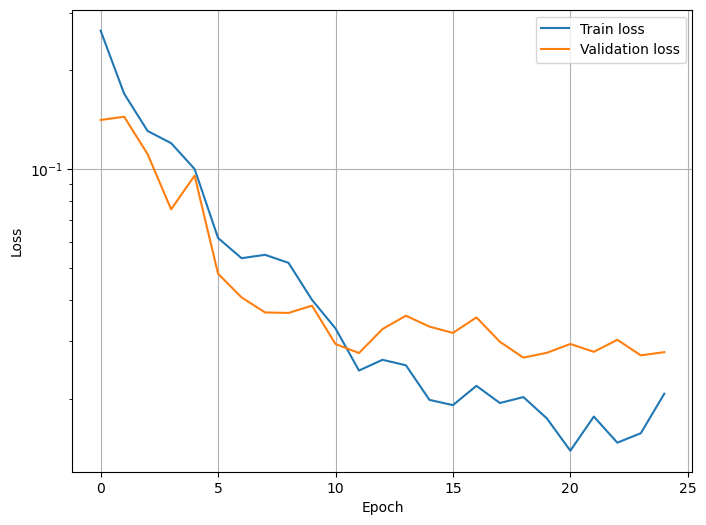

In [34]:
# plot the train and validation loss curve
val_loss=[]
train_loss=[]
for i in range(25):
    val_loss.append(net1.history[i]['valid_loss'])
    train_loss.append(net1.history[i]['train_loss'])
    
plt.figure(figsize=(8,6))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()    

Prediction of the classifier

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=32,
    max_epochs=20,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

net1.initialize()
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam2/params.pt')
y_pred = net1.predict(test_ds)
accuracy2 = accuracy_score(y_test2, y_pred)
print(f'The test accuracy for binary classification:   {round(accuracy2*100,2)}%')

The test accuracy for binary classification:   99.28%


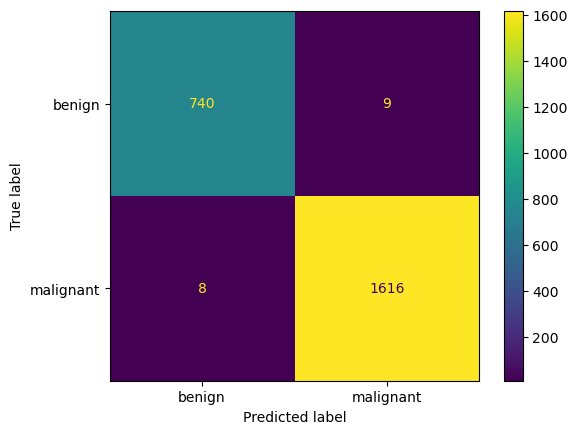

              precision    recall  f1-score   support

      benign     0.9893    0.9880    0.9886       749
   malignant     0.9945    0.9951    0.9948      1624

    accuracy                         0.9928      2373
   macro avg     0.9919    0.9915    0.9917      2373
weighted avg     0.9928    0.9928    0.9928      2373

Accurancy for benign: 0.9928 
Accurancy for malignant: 0.9928 


In [36]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=main_classname)
disp.plot()
plt.show()
print(classification_report(y_test2, y_pred, target_names=main_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(main_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm),4)
    print(f'Accurancy for {cls}: {per_class_accuracies[cls]} ')

Prepare the balanced data  
Over-sampling using SMOTE.

Perform over-sampling using SMOTE. 

In [42]:
from imblearn.over_sampling import SMOTEN
print(f'The train set shape before over-sampling: {train.shape}')
smote = SMOTEN(sampling_strategy='auto',random_state=SEED)
Xtrain_sm = smote.fit_resample(train)
ytrain_sm2 = le.transform(Xtrain_sm.main_type)
print(f"After over sampling, the train set shape : {Xtrain_sm.shape}")

The train set shape before over-sampling: (5536, 4)
After over sampling, the train set shape : (19232, 4)


In [43]:
Xtrain_sm.main_type.value_counts()

benign       9616
malignant    9616
Name: main_type, dtype: int64

Load and transform the image data

Apply transforms.RandomHorizontalFlip() and transforms.RandomVerticalFlip() during loading data to reduce duplicates when add more images for minority class.

In [45]:
# Define class to load and transform image data
torch.manual_seed(SEED)
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),  
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]
        
# Prepare training and validation datasets for binary classfication
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain_sm, ytrain_sm2, test_size=0.25, random_state=SEED)
X_train.name = 'train'
X_valid.name = 'val'
test.name = 'test'
train.name = 'train'

# reset index 
X_train.reset_index(inplace=True)
X_train.drop(columns=['index'],inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'],inplace=True)

train_ds_sm = load_data(X_train,y_train)
valid_ds_sm = load_data(X_valid,y_valid)
test_ds = load_data(test,y_test2)

Train model with Adam optimizer 
Freeze the parameters of layers except full connection layer, train the model with Step LR scheduler and validate with predifined validation set.​

In [46]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [56]:
lrscheduler = LRScheduler(policy='StepLR', step_size=4, gamma=0.3)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_frez_sm')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_frez_sm')

net = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0001,
    batch_size=32,
    max_epochs=15,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_sm),
    callbacks=[lrscheduler,cp,train_end_cp,freezer],
    # device = 'cuda'
)

_ = net.fit(train_ds_sm,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.1760       0.9661        0.0966     +  0.0001  249.6633
      2        0.0913       0.9692        0.0807     +  0.0001  248.5462
      3        0.0733       0.9721        0.0771     +  0.0001  247.4950
      4        0.0624       0.9667        0.0880        0.0001  246.5210
      5        0.0486       0.9738        0.0651     +  0.0000  246.3823
      6        0.0456       0.9767        0.0746        0.0000  246.3895
      7        0.0420       0.9792        0.0635     +  0.0000  248.8125
      8        0.0415       0.9802        0.0536     +  0.0000  246.1870
      9        0.0367       0.9794        0.0537        0.0000  247.9996
     10        0.0353       0.9807        0.0589        0.0000  248.8246
     11        0.0340       0.9800        0.0549        0.0000  250.5046
     12        0.0323       0.9811        0.0603   

Then, unfreeze all freezed parameters, load the above best parameters and train the model with smaller STEP learning rate, validate with test data.

In [57]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.3)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_unfrez_sm')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_unfrez_sm')

net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0002,
    batch_size=32,
    max_epochs=25,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(test_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam_frez_sm/params.pt')
_ = net1.fit(train_ds_sm,y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.0510       0.9587        0.1474     +  0.0002  236.4329
      2        0.0325       0.9654        0.1257     +  0.0002  234.4205
      3        0.0201       0.9659        0.1060     +  0.0002  234.6468
      4        0.0197       0.9621        0.1380        0.0002  236.2244
      5        0.0226       0.9659        0.1274        0.0002  236.4573
      6        0.0094       0.9836        0.0669     +  0.0001  241.6574
      7        0.0030       0.9865        0.0662     +  0.0001  238.7478
      8        0.0040       0.9831        0.0692        0.0001  239.8895
      9        0.0021       0.9831        0.0772        0.0001  238.9536
     10        0.0030       0.9798        0.1018        0.0001  238.9178
     11        0.0027       0.9848        0.07

Train the model with step LR scheduler and validate with predefined validation set.

In [58]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm')

net = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0003,
    batch_size=64,
    max_epochs=15,
    optimizer=optim.Adam,
    #optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

_ = net.fit(train_ds_sm,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.0887       0.9133        0.2514     +  0.0003  225.8608
      2        0.0397       0.9415        0.1719     +  0.0003  226.3168
      3        0.0320       0.9675        0.0858     +  0.0003  226.3133
      4        0.0223       0.9220        0.3259        0.0003  225.2901
      5        0.0231       0.9429        0.1741        0.0003  230.5437
      6        0.0102       0.9812        0.0528     +  0.0001  229.2170
      7        0.0072       0.9740        0.0816        0.0001  227.5540
      8        0.0054       0.9769        0.0968        0.0001  228.8475
      9        0.0046       0.9769        0.0738        0.0001  230.2244
     10        0.0080       0.9718        0.0756        0.0001  231.2364
     11        0.0033       0.9841        0.0558        0.0001  228.8649
     12        0.0013       0.9870        0.0544   

Create new model instance, set smaller lr and no weight decay, load the above model parameters and validate with test set.

In [59]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm1')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm1')
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0001,
    batch_size=32,
    max_epochs=20,
    optimizer=optim.Adam,
    #optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(test_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

net1.initialize() 
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam_sm/params.pt')
_ = net1.fit(train_ds_sm,y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.0143       0.9756        0.0953     +  0.0001  239.8542
      2        0.0079       0.9768        0.1305        0.0001  247.5257
      3        0.0114       0.9781        0.0849     +  0.0001  240.8288
      4        0.0056       0.9794        0.0953        0.0001  239.5305
      5        0.0109       0.9772        0.1126        0.0001  241.4158
      6        0.0059       0.9815        0.0916        0.0001  243.9625
      7        0.0026       0.9810        0.0922        0.0001  239.5361
      8        0.0044       0.9802        0.0860        0.0001  238.4177
      9        0.0044       0.9844        0.0803     +  0.0001  237.3116
     10        0.0021       0.9861        0.0678     +  0.0001  234.9623
     11        0.0018       0.9844        0.08

Prediction of the classifier

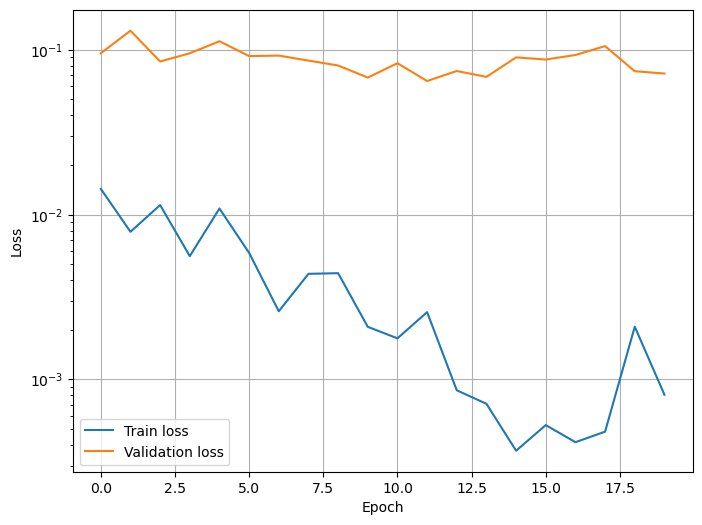

In [60]:
# plot the train and validation loss curve
val_loss=[]
train_loss=[]
for i in range(20):
    val_loss.append(net1.history[i]['valid_loss'])
    train_loss.append(net1.history[i]['train_loss'])
    
plt.figure(figsize=(8,6))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()  

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
The test accuracy for binary classification:   98.44%


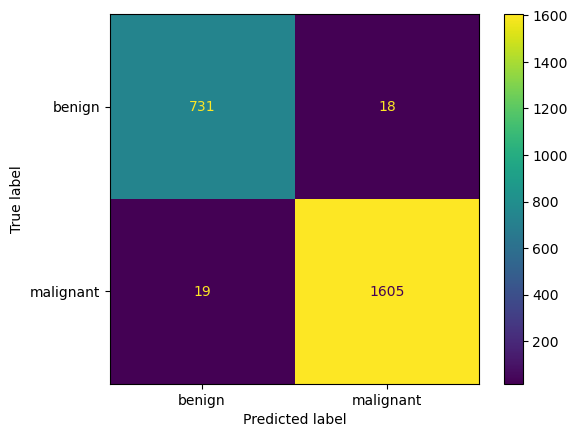

              precision    recall  f1-score   support

      benign     0.9747    0.9760    0.9753       749
   malignant     0.9889    0.9883    0.9886      1624

    accuracy                         0.9844      2373
   macro avg     0.9818    0.9821    0.9820      2373
weighted avg     0.9844    0.9844    0.9844      2373

Accurancy for benign: 98.44% 
Accurancy for malignant: 98.44% 


In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

net1.initialize()
net1.load_params(f_params='C:/Users/aggou/Downloads/archive/record/Adam_sm1/params.pt')
y_pred = net1.predict(test_ds)
accuracy2 = accuracy_score(y_test2, y_pred)
print(f'The test accuracy for binary classification:   {round(accuracy2*100,2)}%')


cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=main_classname)
disp.plot()
plt.show()
print(classification_report(y_test2, y_pred, target_names=main_classname, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(main_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
    print(f'Accurancy for {cls}: {per_class_accuracies[cls]}% ')

In [ ]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
cp = Checkpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm2')
train_end_cp = TrainEndCheckpoint(dirname='C:/Users/aggou/Downloads/archive/record/Adam_sm2')
net1 = NeuralNetClassifier(
    PretrainedModel(2), 
    criterion=nn.CrossEntropyLoss,
    lr=0.0002,
    batch_size=32,
    max_epochs=20,
    optimizer=optim.Adam,
    optimizer__weight_decay=5e-4,
    iterator_train__shuffle=True, 
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False, 
    iterator_valid__num_workers=2,
    train_split=predefined_split(test_ds),
    callbacks=[lrscheduler,cp,train_end_cp],
    # device = 'cuda'
)

_ = net1.fit(train_ds_sm,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.0993       0.9351        0.1739     +  0.0002  234.2721
      2        0.0517       0.9397        0.9346        0.0002  234.8614
      3        0.0421       0.9418        0.4081        0.0002  233.4145
      4        0.0365       0.9368        0.2073        0.0002  234.6142
      5        0.0376       0.9216        0.2182        0.0002  235.2569
      6        0.0199       0.9747        0.0791     +  0.0001  234.2216
      7        0.0197       0.9562        0.1221        0.0001  234.1259
      8        0.0203       0.9684        0.0977        0.0001  227.3811
      9        0.0231       0.9654        0.1092        0.0001  228.4239
     10        0.0286       0.9625        0.4123        0.0001  227.2633
     11        0.0151       0.9701        0.1210        0.0001  230.7875
     12        0.0113       0.9760        0.0819   